# Thinkful Capstone \#2 - US Domestic Flights (1990 - 2009)

## Introduction:

The [dataset](http://academictorrents.com/details/a2ccf94bbb4af222bf8e69dad60a68a29f310d9a) used in designing this experiment was compiled by the US Census Bureau in 2009 and contains over 3.5 million rows of information regarding domestic flights within the United States between 1990 and 2009. Any values used in the visualizations have unit values included for clarification purposes. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

## Data Loading, Extraction, and Cleaning

In [2]:
import csv

my_file = r'C:\Users\Amichai\Documents\Thinkful\Module 14 - Experimental Design\flight_edges.tsv'

#Initialize variable for each column
headers = ['Orig Code', 'Dest Code', 'Orig City', 'Dest City', 'Num Passengers', 'Num Seats', 'Num Flights', 'Distance', 'Fly Date', 'Orig Population', 'Dest Population']
origincode = []
destcode = []
origincity = []
destcity = []
numpass = []
numseat = []
numflights = []
dist = []
date = []
originpop = []
destpop = []
var_names = [origincode, destcode, origincity, destcity, numpass, numseat, numflights, dist, date, originpop, destpop]

data = pd.DataFrame(columns = headers)

with open(my_file) as tsvfile:
  reader = csv.reader(tsvfile, delimiter='\t')
  for row in reader:
    for i in range(len(row)):
        if var_names[i] in [date,origincode,destcode,origincity,destcity]:
             var_names[i].append(row[i])
        else:
            try:
                var_names[i].append(float(row[i]))
            except:
                var_names[i].append(row[i]) 

#Convert dates to more usable MM/YYYY string format: Originally in YYYYMM string format
for i in range(len(date)):
    date[i] = date[i][4:] + '/' + date[i][:4]         
            
#Save all variable lists to dataframe
for j in range(len(headers)):
    data[headers[j]] = var_names[j]

In [3]:
data.describe()

,Orig Population,Dest Population
count,3.606803e+06,3.606803e+06
mean,5.871502e+06,5.897982e+06
std,7.858062e+06,7.906127e+06
min,1.300500e+04,1.288700e+04
25%,1.030597e+06,1.025470e+06
50%,2.400193e+06,2.400193e+06
75%,8.613622e+06,8.635706e+06
max,3.813959e+07,3.813959e+07


In [5]:
#Sort dataset by date
data = data.sort_values('Fly Date')

#Reset index
data = data.reset_index(drop=True)

In [7]:
#Fix distance values still in str format (these were causing issues with the histogram)

for i in range(len(data['Distance'])):
    if type(data['Distance'][i]) != float:
        try:
            data['Distance'][i] = float(data['Distance'][i])
        except:
            data['Distance'][i] = np.nan
        
        print(i, ' : ', data['Distance'][i])


C:\Users\Amichai\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


2958979  :  254.0


In [14]:
data.head()

,Orig Code,Dest Code,Orig City,Dest City,Num Passengers,Num Seats,Num Flights,Distance,Fly Date,Orig Population,Dest Population
0,LAX,SJC,"Los Angeles, CA","San Jose, CA",11815,29678,209,308,01/1990,22585772.0,1534472.0
1,PDX,SEA,"Portland, OR","Seattle, WA",873,3528,24,129,01/1990,1534762.0,5154164.0
2,PDX,SEA,"Portland, OR","Seattle, WA",144,540,5,129,01/1990,1534762.0,5154164.0
3,DAY,GSO,"Dayton, OH","Greensboro, NC",57,146,1,351,01/1990,844660.0,541858.0
4,PDX,SEA,"Portland, OR","Seattle, WA",6,109,1,129,01/1990,1534762.0,5154164.0


## Initial exploration of the dataset

In [10]:
print('Shape: ', data.shape)

Shape:  (3606803, 11)


In [11]:
percent_occ = []
diff_pop = []

#New columns, ratio of num passengers to num seats and difference in populations
for i in range(len(data)):
    try:
        percent_occ.append(round((float(data['Num Passengers'][i]))/float(data['Num Seats'][i]),4))
    except:
        percent_occ.append(np.nan)
        
    try:
        diff_pop.append(abs(float(data['Dest Population'][i])-float(data['Orig Population'][i])))
    except:
        percent_occ.append(np.nan)
        
data['Percent Occupancy'] = percent_occ
data['Difference Between Populations'] = diff_pop

print(data['Percent Occupancy'][:5])
print('\n')
print(data['Difference Between Populations'][:5])


0    0.3981
1    0.2474
2    0.2667
3    0.3904
4    0.0550
Name: Percent Occupancy, dtype: float64


0    21051300.0
1     3619402.0
2     3619402.0
3      302802.0
4     3619402.0
Name: Difference Between Populations, dtype: float64


In [12]:
#Check how many rows have non-sensical values (can't have more passengers than seats, i.e. Occupancy > 1)

print(len(data.iloc[list(np.where(data['Percent Occupancy']>1)[0])]))

#Only 270/3,000,000+ rows contain non-sensical Occupancy values. 
#We can afford to drop those rows from the analysis.


270


In [13]:
#Although technically possible, it doesn't make much sense for a flight to have 0 passengers.
#Should we drop those rows? How many are there?

print(len(data[data['Percent Occupancy']<=0]))

# ~52,000/3,000,000 might cause issues. However, this is a value of 0.017, which is less than the 
# classic p-value cutoff of 0.05, so I feel comfortable dropping those rows from the analysis too.

51866


In [15]:
#Drop rows w/ non-sensical occupancies
data = data[data['Percent Occupancy']<=1]
data = data[data['Percent Occupancy']>0]

#Check if successful
print(len(data.iloc[list(np.where(data['Percent Occupancy']>1)[0])]))
print(len(data.iloc[list(np.where(data['Percent Occupancy']==0)[0])]))

#Reset index
data = data.reset_index(drop=True)

0
0


In [17]:
#Determine counts of each unique Percent Occupancy value:
po = data['Percent Occupancy'].value_counts()
print('Percent Occupancies: \n', po)

#Determine counts of each unique Distance value:
dis = data['Distance'].value_counts()
print('\nDistances Traveled (Miles): \n', dis)

#Determine counts of each unique Population Difference value:
popdif = data['Difference Between Populations'].value_counts()
print('\nPopulation Differences (Num. People): \n', popdif)


Percent Occupancies: 
 1.0000    29571
0.5000     7313
0.9000     4780
0.8000     4509
0.7500     4254
0.7000     3805
0.6667     3738
0.6000     3625
0.9600     3406
0.9400     3398
0.9200     3395
0.9800     3339
0.8800     3300
0.8600     3098
0.8333     3061
0.8400     2992
0.8200     2974
0.7800     2791
0.7600     2725
0.7200     2651
0.7400     2519
0.4000     2507
0.6800     2461
0.6600     2377
0.6400     2338
0.3333     2299
0.6200     2254
0.5800     2129
0.5600     2111
0.8750     2027
          ...  
0.0257        2
0.0406        2
0.0334        2
0.0572        2
0.0005        2
0.0623        2
0.9995        2
0.0186        2
0.0313        2
0.0416        2
0.0277        2
0.9997        2
0.0009        2
0.0251        2
0.0170        2
0.0006        2
0.0624        2
0.0271        2
0.0499        2
0.9996        2
0.0363        2
0.0307        2
0.0285        1
0.0295        1
0.0016        1
0.0030        1
0.9991        1
0.0171        1
0.0188        1
0.0332        1
N

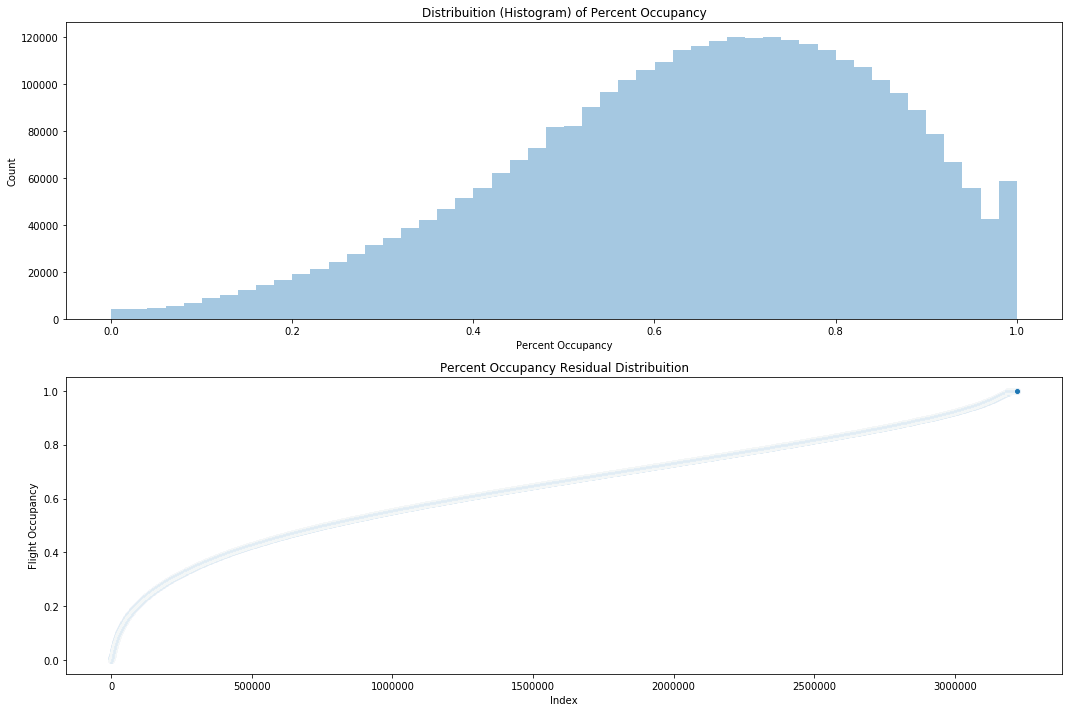

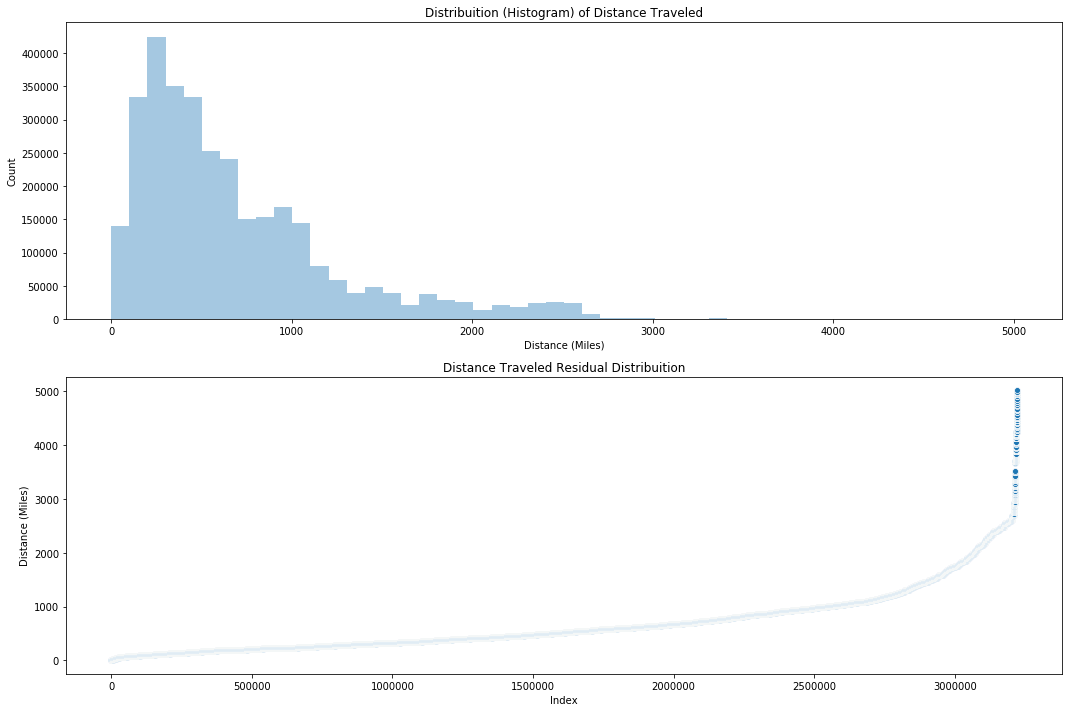

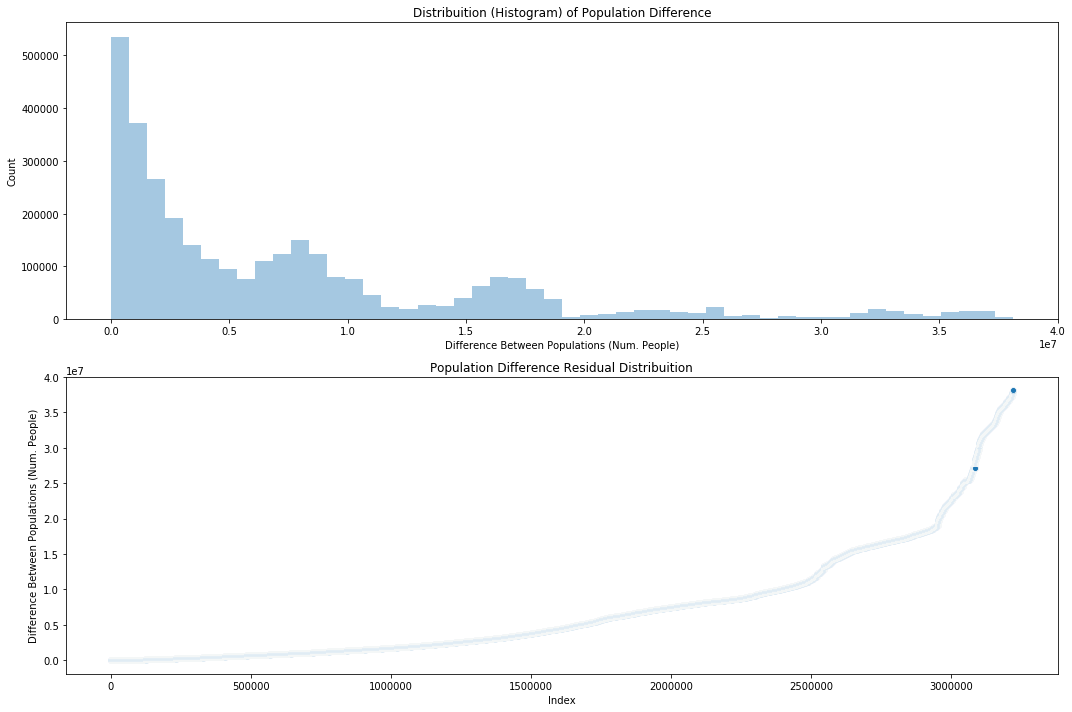

In [19]:
#Visualize occupancy data
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
ax = sns.distplot(data['Percent Occupancy'], kde=False, norm_hist = False)
ax.set(title = 'Distribuition (Histogram) of Percent Occupancy', xlabel = 'Percent Occupancy', ylabel = 'Count')

plt.subplot(2,1,2)
ax2 = sns.scatterplot(range(data.shape[0]), np.sort(data['Percent Occupancy'].values))
ax2.set(title='Percent Occupancy Residual Distribuition', xlabel='Index',ylabel='Flight Occupancy')

plt.tight_layout()
plt.show()



#Visualize distance data
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
ax3 = sns.distplot(data['Distance'].astype(float), kde=False, norm_hist = False)
ax3.set(title = 'Distribuition (Histogram) of Distance Traveled', xlabel = 'Distance (Miles)', ylabel = 'Count')

plt.subplot(2,1,2)
ax4 = sns.scatterplot(range(data.shape[0]), np.sort(data['Distance'].values.astype(float)))
ax4.set(title='Distance Traveled Residual Distribuition', xlabel='Index',ylabel='Distance (Miles)')

plt.tight_layout()
plt.show()



#Visualize population difference data
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
ax5 = sns.distplot(data['Difference Between Populations'], kde=False, norm_hist = False)
ax5.set(title = 'Distribuition (Histogram) of Population Difference', xlabel = 'Difference Between Populations (Num. People)', ylabel = 'Count')

plt.subplot(2,1,2)
ax6 = sns.scatterplot(range(data.shape[0]), np.sort(data['Difference Between Populations'].values))
ax6.set(title='Population Difference Residual Distribuition', xlabel='Index',ylabel='Difference Between Populations (Num. People)')

plt.tight_layout()
plt.show()

In [20]:
#Sort dataframe by categories: >50% occupancy, and <=50% occupancy
high_occ = data.loc[data['Percent Occupancy'] > 0.5]
low_occ = data.loc[data['Percent Occupancy'] <= 0.5]


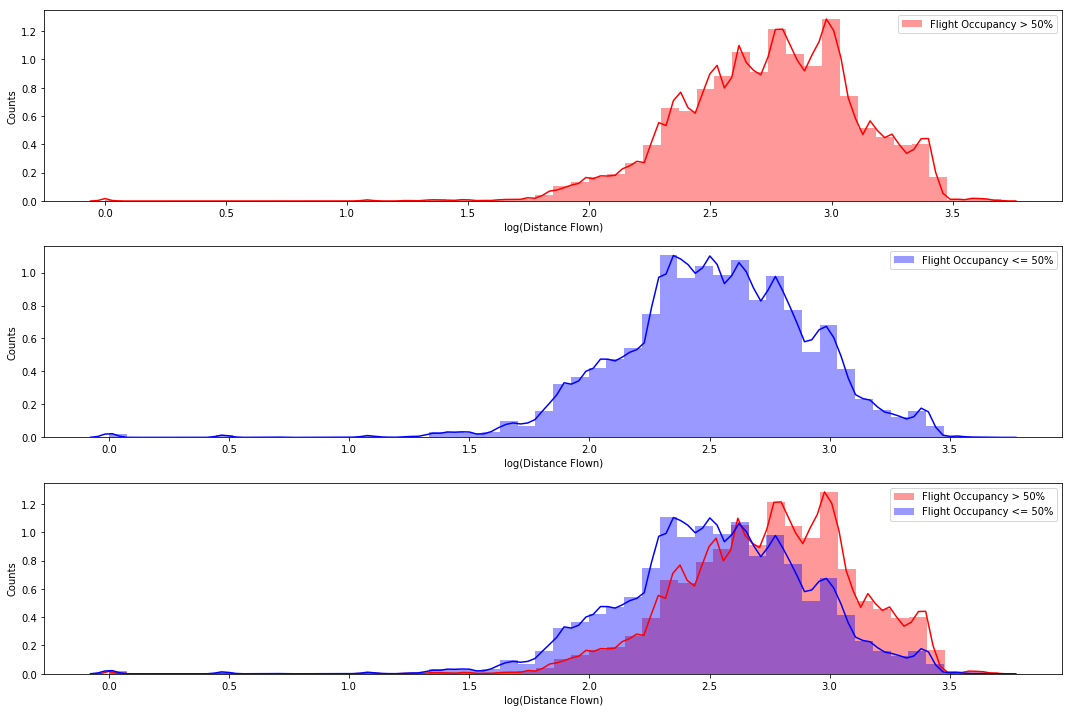

In [21]:
#Plot comparison of distances traveled when separated by flight occupancy

plt.figure(figsize=(15,10))

plt.subplot(311)
sns.distplot(np.log10(high_occ['Distance'].astype(float)+1), norm_hist = False, color='r', label='Flight Occupancy > 50%')
plt.legend(loc='upper right')
plt.ylabel('Counts')
plt.xlabel('log(Distance Flown)')

plt.subplot(312)
sns.distplot(np.log10(low_occ['Distance'].astype(float)+1), norm_hist = False, color='b', label='Flight Occupancy <= 50%')
plt.legend(loc='upper right')
plt.ylabel('Counts')
plt.xlabel('log(Distance Flown)')

plt.subplot(313)
sns.distplot(np.log10(high_occ['Distance'].astype(float)+1), norm_hist = False, color='r', label='Flight Occupancy > 50%')
sns.distplot(np.log10(low_occ['Distance'].astype(float)+1), norm_hist = False, color='b', label='Flight Occupancy <= 50%')
plt.legend(loc='upper right')
plt.ylabel('Counts')
plt.xlabel('log(Distance Flown)')


plt.tight_layout()
plt.show()

The above visualizations show that flight occupancy does seem to have a correlation to the distance of the flights, with the trend showing that shorter flights tend to have a smaller proportion of passengers (i.e. short flights tend to have more unsold seats).

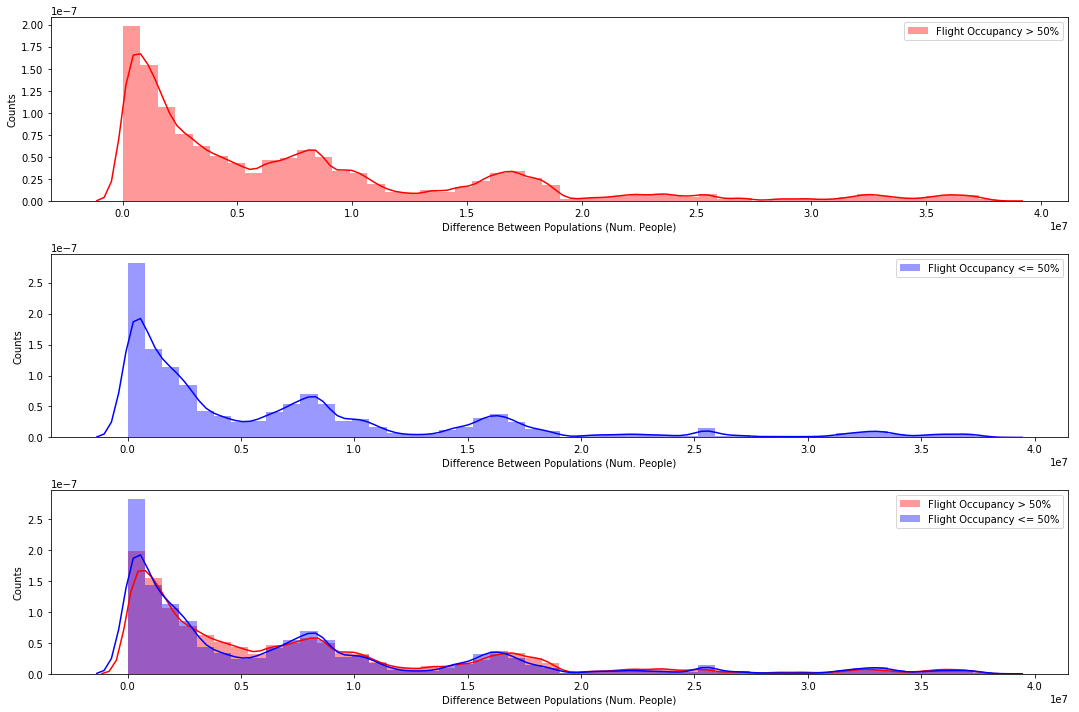

In [22]:
#Plot comparison of population differences when separated by flight occupancy

plt.figure(figsize=(15,10))

plt.subplot(311)
sns.distplot(high_occ['Difference Between Populations'], norm_hist = False, color='r', label='Flight Occupancy > 50%')
plt.legend(loc='upper right')
plt.ylabel('Counts')
plt.xlabel('Difference Between Populations (Num. People)')

plt.subplot(312)
sns.distplot(low_occ['Difference Between Populations'], norm_hist = False, color='b', label='Flight Occupancy <= 50%')
plt.legend(loc='upper right')
plt.ylabel('Counts')
plt.xlabel('Difference Between Populations (Num. People)')

plt.subplot(313)
sns.distplot(high_occ['Difference Between Populations'], norm_hist = False, color='r', label='Flight Occupancy > 50%')
sns.distplot(low_occ['Difference Between Populations'], norm_hist = False, color='b', label='Flight Occupancy <= 50%')
plt.legend(loc='upper right')
plt.ylabel('Counts')
plt.xlabel('Difference Between Populations (Num. People)')

plt.tight_layout()
plt.show()

These visualizations show that the population difference between the origin and destination cities does not seem to have much of an impact on the occupancy of the respective flight. In other words, the proportion of empty seats on a flight is around the same for a flight going between similarly sized cities as it is for cities with a large difference in size/population.

In [24]:
#Dates are strings in a Series. To pull out the month for each date, we need to create a new list.
months = []
month_split = data['Fly Date'].str.split('/')

for i in range(len(month_split)):
    months.append(month_split[i][0])

In [25]:
#Sort dataframe by time of year/season
months = np.array(months)   #convert list to array

#Determine indexes opf all data points that correlate to each season (based on month in date)
winter_inds = list(np.where((months == '12')|(months=='01')|(months=='02'))[0])
spring_inds = list(np.where((months == '03')|(months=='04')|(months=='05'))[0])
summer_inds = list(np.where((months == '06')|(months=='07')|(months=='08'))[0])
fall_inds = list(np.where((months == '09')|(months=='10')|(months=='11'))[0])

#Winter: December, January, February
winter_data = data.loc[winter_inds]

#Spring: March, April, May
spring_data = data.loc[spring_inds]

#Summer: June, July, August
summer_data = data.loc[summer_inds]

#Fall: September, October, November
fall_data = data.loc[fall_inds]


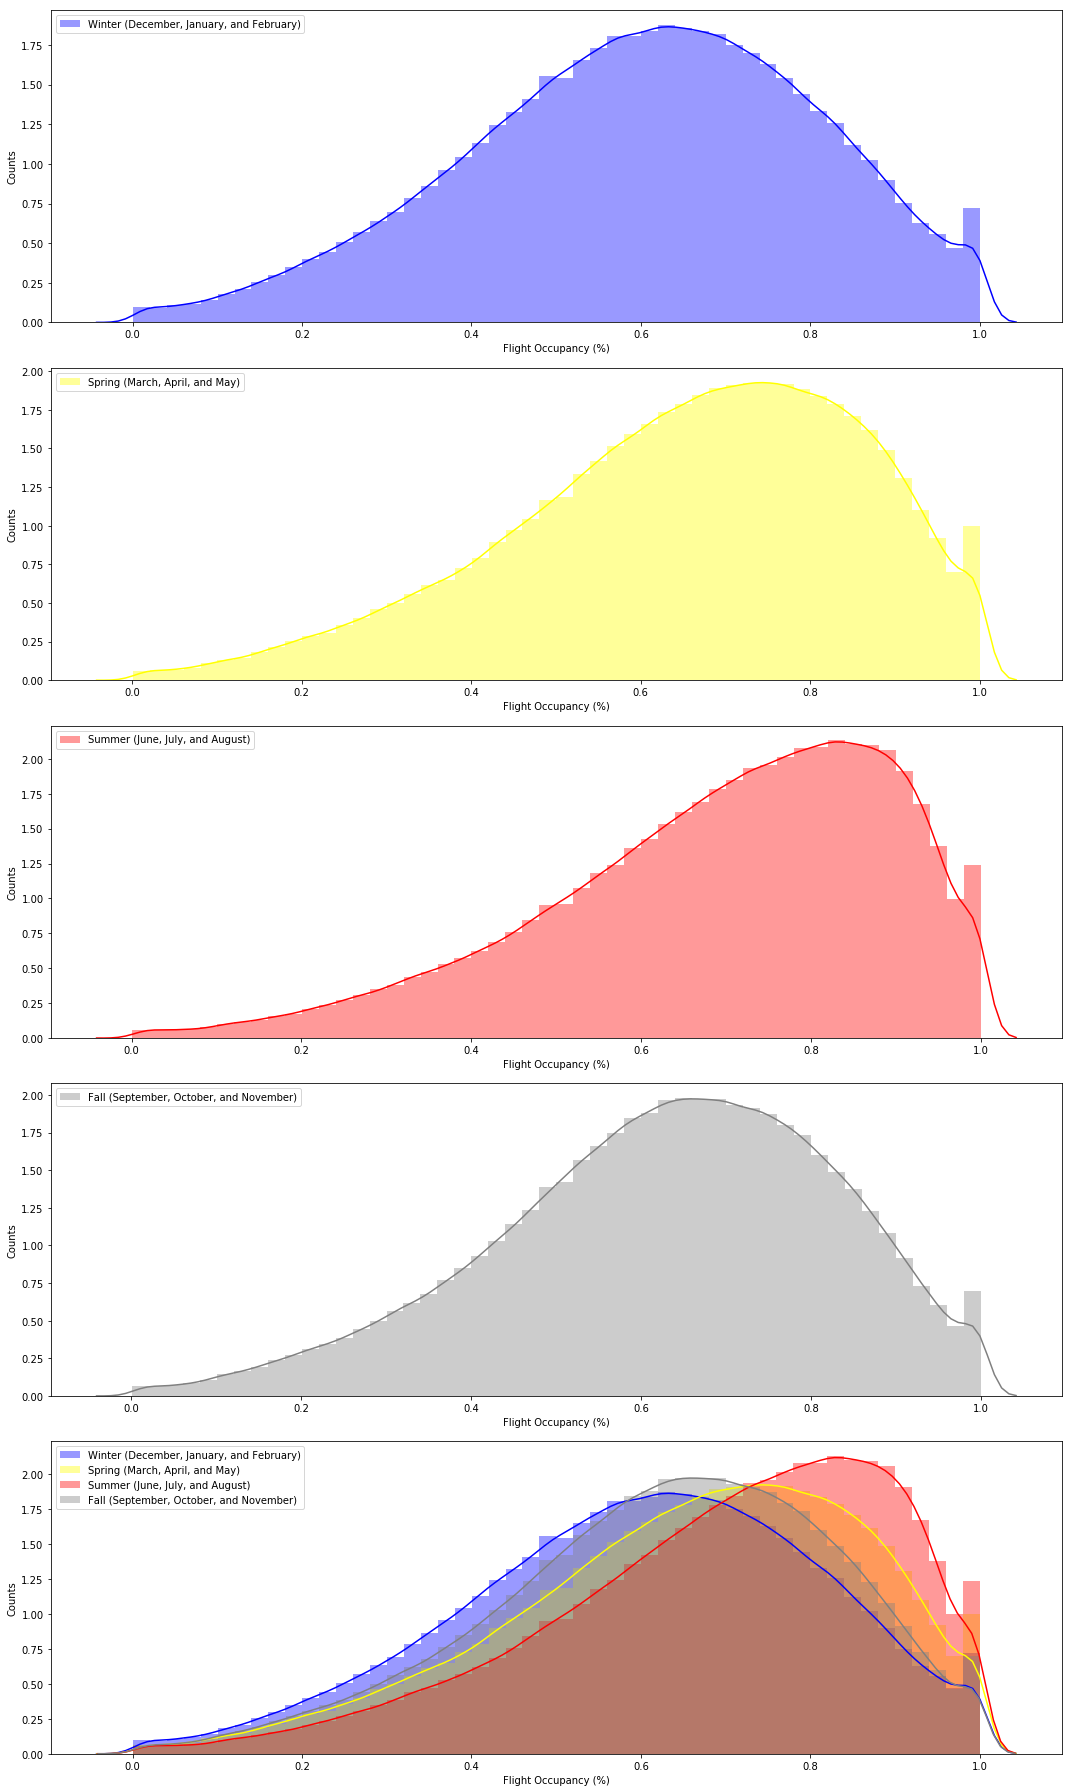

In [28]:
#Plot comparison of flight occupancy when separated by time of year/season

plt.figure(figsize=(15,25))

plt.subplot(511)
sns.distplot(winter_data['Percent Occupancy'], norm_hist = False, color='blue', label='Winter (December, January, and February)')
plt.legend(loc='upper left')
plt.ylabel('Counts')
plt.xlabel('Flight Occupancy (%)')

plt.subplot(512)
sns.distplot(spring_data['Percent Occupancy'], norm_hist = False, color='yellow', label='Spring (March, April, and May)')
plt.legend(loc='upper left')
plt.ylabel('Counts')
plt.xlabel('Flight Occupancy (%)')

plt.subplot(513)
sns.distplot(summer_data['Percent Occupancy'], norm_hist = False, color='red', label='Summer (June, July, and August)')
plt.legend(loc='upper left')
plt.ylabel('Counts')
plt.xlabel('Flight Occupancy (%)')

plt.subplot(514)
sns.distplot(fall_data['Percent Occupancy'], norm_hist = False, color='gray', label='Fall (September, October, and November)')
plt.legend(loc='upper left')
plt.ylabel('Counts')
plt.xlabel('Flight Occupancy (%)')


plt.subplot(515)
sns.distplot(winter_data['Percent Occupancy'], norm_hist = False, color='blue', label='Winter (December, January, and February)')
sns.distplot(spring_data['Percent Occupancy'], norm_hist = False, color='yellow', label='Spring (March, April, and May)')
sns.distplot(summer_data['Percent Occupancy'], norm_hist = False, color='red', label='Summer (June, July, and August)')
sns.distplot(fall_data['Percent Occupancy'], norm_hist = False, color='gray', label='Fall (September, October, and November)')
plt.legend(loc='upper left')
plt.ylabel('Counts')
plt.xlabel('Flight Occupancy (%)')


plt.tight_layout()
plt.show()

These visualizations point to a significant difference between different times of the year and their respective flight occupancies. Fall and winter seem to have the lowest occupancies, which implies that people tend to fly more in spring and summer, which makes sense to some extent, especially for summer, as that's when people tend to have vacation time. 

## Research Proposal:
In what ways can United States domestic airlines improve their profits by increasing the ratio of passengers per flight?
The current data, collected between 1990 and 2009, shows correlations between both time of year/season and total distance flown, when compared with the percent occupancy of a given flight. Having low occupancy on a flight is likely to drive down profits, as each flight has a fixed cost, and the added variable cost of each additional passenger is minimal in comparison.

## Experimental Hypothesis:
Domestic US airlines can improve revenue by providing discounts or other incentives to passengers flying during low-demand periods of time or for relatively short distances.

## Rollout Plan:
Over the next year, the airline for which we have been contracted will run several new promotions with the intention of increasing target conversion, particularly among passengers who tend not to fly shorter distances nor during lower-traffic time periods. Through these promotions, hopefully ticket sales will increase, thereby increasing overall revenues and profits.

The discounts will be offered on a sliding scale depending on the relative demand for each season/ travel distance (based on the trends shown in the visualizations above). The discounts will be most concentrated on the fall and winter months (September-February) and on "short" flight distances(<500 miles). This plan must be executed for at least 12 months, as any other length of time would not take all seasonal travel trends into account, and may skew our results. 

## Evaluation Plan:
After the year of testing has been completed, the changes in passenger occupancy for each flight will be compared to the trends found over the 1990-2009 time period. If flight occupancy and/or profit for the airline increased more than one standard deviation compared to the averages from the current data, then it can be concluded that the experiment was a success. If occupancy and profits increased, but not more than one standard deviation, the experiment should be extended another year to determine if it was a random fluke, or if the data sample just wasn't large enough. Finally, if flight occupancy and/or profits went down compared with the 20 year average already investigated, then we should conclude that the experiment was a failure and proceed with some other strategy for improving airline profits. 
Further research could include analysis into how trends have changed over the years (for example, perhaps we could analyze pre- and post-9/11 flying habits) to see if any of those trends could be translated into actionable marketing potential. 